# ChemTab (PCDNN_V2) Benchmark Notebook
### This notebook contains experiments around the different parameters for the model
#### Amol Salunkhe

Develop a deep neural architecture ChemTab that jointly optimizes two neural networks for the tasks of reduced basis learning (encoder) and reverse lookup function learning (regressor). The first network (Shallow AutoEncoder) will focus on linear dimensionality reduction and create a linear embedding for the source species. The second network (Deep Regressor) will focus on learning a lookup function from the linear embedding to the Thermo-chemical state variables.


### Progress variable(s) 
The progress variable $C_i$ is commonly defined from a combination of reactive scalars such as chemical species or temperature. Although its definition is not unique, the choice of a suitable progress variable should be guided by the following
principles:

- The definition of $C_i$ should result in a transport equation that can be conveniently solved in a combustion simulation.
- The reactive scalars from which $C_i$ is constructed should all evolve on comparable time scales.
- All parameters that define the manifold should be independent of one another.
- The set of parameters from which the manifold is formed should uniquely characterize each point in the thermochemical state-space.


### Overall Problem Formulation

\begin{equation}\label{eqn:lossfunc}
    \begin{aligned}
    \textrm{min} \quad \mathcal{L}_{joint} = \lambda_{encoder} * \mathcal{L}_{encoder} + \lambda_{regressor}* \mathcal{L}_{regressor} 
    \end{aligned}
\end{equation}

### Reduced Basis Problem Formulation (Encoder)

\begin{equation}\label{eqn:Reduced-Basis-Learning}
    \begin{aligned}
    \def\sss{\scriptscriptstyle}
    {}
    \def\stacktype{L}
        {\mathrm{Y^{'}}}{\sss n\times k} =  {Y}{\sss n\times s} \times {W}{\sss s\times k} \\
        \textrm{s.t.,} \quad k \ll s\\
        \quad Y^{'T}Y^{'} = I\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
        \textrm{where, W is the Reduced Basis / encoder} \\
        \mathrm{\phi} \quad \textrm{is the Reverse Lookup function / regressor}
    \end{aligned}
\end{equation}


### Lookup Learning Problem Formulation (Regressor)

\begin{equation}\label{eqn:Reverse-Lookup-Learning}
    \begin{aligned}
        \textrm{min} \quad ||{S_i} - \mathrm{\phi}(Y^{'}_i)||_{p}\\
        \textrm{s.t.,} \quad p \in R \\
        \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
    \end{aligned}
\end{equation}



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

# Load and prepare data

In [2]:
class PositiveLogNormal:
    def __init__(self):
        self.max_value = 0
        return
    
    def set_max_value(self,max_value):
        self.max_value = max_value
        return 
    
    def get_max_value(self):
        return self.max_value
        
    def fit_transform(self,data):
        temp = pd.DataFrame(data=data, columns=["target"])
        max_value = temp["target"].max()
        self.set_max_value(max_value)
        #2*self.set_max_value --> to account for max that may be out of this dataset
        temp['transfomed'] = temp.apply(lambda row: np.log1p((row.target + 2*self.max_value)), axis=1)
        transfomed_data = temp['transfomed'].values
        transfomed_data = transfomed_data.reshape(transfomed_data.shape[0], 1)
        return transfomed_data
    
    def inverse_transform(self,transformeddata):
        #todo: complete this
        temp = pd.DataFrame(data=transformeddata, columns=["target"])
        temp['inverse'] = temp.apply(lambda row:  np.expm1((row.target)) - 2*self.max_value, axis=1)
        data = temp['inverse'].values
        data = data.reshape(data.shape[0], 1)
        return data

In [3]:
class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = tf.transpose(w)
        if(self.encoding_dim > 1):
            m = tf.matmul(tf.transpose(w), w) - tf.eye(self.encoding_dim)
            return self.weightage * tf.math.sqrt(tf.math.reduce_sum(tf.math.square(m)))
        else:
            m = tf.math.reduce_sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
    def get_config(self):
        return {'axis':self.axis,'weightage':self.weightage,'encoding_dim':self.encoding_dim}
    

class UncorrelatedFeaturesConstraint (Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        
        self.weightage = weightage

        self.covariance = None
        
    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - tf.math.reduce_mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        
        covariance = tf.matmul(x_centered, tf.transpose(x_centered)) / tf.cast(x_centered.get_shape()[0], tf.float32)
        #covariance = tf.matmul(x_centered, tf.transpose(x_centered)) / tf.cast(tf.shape(x_centered)[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = tf.math.reduce_sum(tf.math.square(self.covariance - tf.math.multiply(self.covariance, tf.eye(self.encoding_dim))))
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)
    
    def get_config(self):
        return {'weightage': self.weightage, 'encoding_dim':self.encoding_dim}


In [4]:
def getIntermediateLayers(x):
    x = layers.Dense(4, activation="relu")(x)
    '''
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    '''
    return x

def getLinearLayer(noOfInputNeurons,noOfCpv,kernel_constraint='Y',kernel_regularizer='Y',activity_regularizer='Y'):
    if kernel_constraint=='Y'and kernel_regularizer =='N' and activity_regularizer =='N':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_constraint=UnitNorm(axis=0))

    elif kernel_constraint=='N'and kernel_regularizer =='Y' and activity_regularizer =='N':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0))

    elif kernel_constraint=='N'and kernel_regularizer =='N' and activity_regularizer =='Y':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))

    elif kernel_constraint=='Y'and kernel_regularizer =='Y' and activity_regularizer =='N':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0))

    elif kernel_constraint=='Y'and kernel_regularizer =='N' and activity_regularizer =='Y':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_constraint=UnitNorm(axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))

    elif kernel_constraint=='N'and kernel_regularizer =='Y' and activity_regularizer =='Y':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))

    elif kernel_constraint=='N'and kernel_regularizer =='N' and activity_regularizer =='N':
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear")

    else:
        layer = layers.Dense(noOfCpv,use_bias=False, name="linear_embedding", activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))
    return layer

In [5]:
noOfInputNeurons = 3
noOfCpv = 2
kernel_constraint = 'Y'
kernel_regularizer = 'Y'
activity_regularizer = 'Y'

species_inputs = keras.Input(shape=(noOfInputNeurons,), name="species_input")
        
linearLayer = getLinearLayer(noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)(species_inputs)

autoencoder = keras.Model(inputs=[species_inputs],outputs=[linearLayer],) 

autoencoder.summary()

zmix = keras.Input(shape=(1,), name="zmix")

combined_model_input = [zmix, species_inputs]

x = layers.Concatenate(name="concatenated_zmix_linear_embedding")([zmix,linearLayer])

x = getIntermediateLayers(x)

#"souener","souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"
souener_pred = layers.Dense(8, name="prediction")(x)

regressor = keras.Model(inputs=combined_model_input,outputs=[souener_pred],) 

regressor.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 species_input (InputLayer)  [(None, 3)]               0         
                                                                 
 linear_embedding (Dense)    (None, 2)                 6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 zmix (InputLayer)              [(None, 1)]       

In [6]:
#read the data into a dataframe
df = pd.read_csv('~/rom_project2/src/NewData_flames_data_with_L1_L2_errors_CH4-AIR_without_trimming(SouSpec_Included).txt')


#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer representation of the flame-id and add to the data frame
df['X_int'] = df['X'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


cut_labels = ['0.0 - 0.11', '0.11 - 0.22', '0.22 - 0.33', '0.33 - 0.44', '0.44 - 0.55', '0.55 - 0.66','0.66 - 0.77', '0.77 - 0.88', '0.88 - 0.99', '0.99 - 1.1']
cut_bins = np.linspace(0, 1.1, 11) 
#df['Xpos_bins'] = pd.cut(df['Xpos'], bins=cut_bins, labels=cut_labels)
df['X_bins'] = pd.cut(df['X'], bins=cut_bins, labels=cut_labels)


In [7]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()

def getTrainTestFlames(method):
    training_flames_int = []
    testing_flames_int = []

    if(method == "frameworkincludedexcludedequalsplit"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int[::2]:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int[1::2]:
            testing_flames_int.append(x)
    elif(method == "frameworkincludedtrainexcludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
    elif(method == "frameworkincludedtrainexcludedandincludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
    else:
        for x in all_flames_int:
            training_flames_int.append(x)
            testing_flames_int.append(x)
    
    df_training = df[df['flame_key_int'].isin(training_flames_int)]

    df_testing = df[df['flame_key_int'].isin(testing_flames_int)]
    
    return df_training,df_testing


def getTrainTestData(method):
    
    method_parts = method.split('_')

    df_trainingFlames, df_testingFlames = getTrainTestFlames(method_parts[1])

    if method_parts[0] == "ZmixCpv":
        X_train = df_trainingFlames [["Zmix","Cpv"]].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [["Zmix","Cpv"]].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "ZmixPCA":
        X_train = df_trainingFlames [zmix_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [zmix_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    elif method_parts[0] == "SparsePCA":
        X_train = df_trainingFlames [sparse_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [sparse_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "PurePCA":
        X_train = df_trainingFlames [pure_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [pure_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    else:
        X_train = df_trainingFlames [icovariates].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [icovariates].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    return X_train,Y_train,X_test,Y_test

In [8]:
def computeError (Y_pred, Y_test):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

    evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']
    
    evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 
    
    TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

    TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()
    
    MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

    MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()
    
    NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()
    
    MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints
    
    return [MeanAbsoluteError,TotalAbsoluteError,MeanPercentageError,MeanSquaredError,TotalSquaredError,NumPoints]

def printError (err):
    MeanAbsoluteError = err[0]
    TotalAbsoluteError = err[1]
    MeanPercentageError = err[2]
    MeanSquaredError = err[3]
    TotalSquaredError = err[4]
    NumPoints = err[5]
    print ('Total Absolute Error: ', TotalAbsoluteError)
    print ('Mean Absolute Error: ', MeanAbsoluteError)
    print ('Mean Percentage Error: ', MeanPercentageError)
    print ('Total Squared Error: ', TotalSquaredError)
    print ('Mean Squared Error: ', MeanSquaredError)
    print ('Number of Points: ', NumPoints)

def computeAndPrintError(Y_pred, Y_test):    
    err = computeError (Y_pred, Y_test)
    printError (err)
    return err

def computeErrorAcrossDependents(Y_pred_df, Y_test_df):    
    err_data = []
    for dependent in dependents:
        Y_pred = Y_pred_df[dependent].values
        Y_test = Y_test_df[dependent].values
        err = computeError (Y_pred, Y_test)
        err.insert(0,dependent)
        err_data.append(err)
    err_df = pd.DataFrame(data=err_data, columns=["Dependent","Mean ABS","Total ABS","Mean Pct Err","Mean SSE","Total SSE", "#Pts" ])
    err_df.drop(columns=["Mean Pct Err","Mean SSE","Total SSE"], inplace=True)
    return err_df


## DNN Method Support Functions

In [9]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['actual'] = Y_test.flatten()

    evaluation_df_1['prediction'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['actual'] - evaluation_df_1['prediction'] 
   
    return evaluation_df_1['res'].values


In [10]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [All Souspecs + Souener]')
    plt.legend()
    plt.grid(True)
    
   

In [11]:
def plot_loss_physics_and_regression(history):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

In [16]:
def getLinearEncoder(dnn):
        
    input_layer = None

    linear_embedding_layer = None

    zmix_layer =  None

    for layer in dnn.layers:
        print(layer.name)            
        if layer.name == "species_input":
            input_layer = layer
        if layer.name == "zmix":
            zmix_layer = layer
        if layer.name == "linear_embedding":
            linear_embedding_layer = layer

    if zmix_layer is not None:
        model = tf.keras.Model ([input_layer.input],[linear_embedding_layer.output])

    else:
        model = tf.keras.Model ([input_layer.input],[linear_embedding_layer.output])

    model.summary()

    return model
    
def getRegressor(dnn):

    #Copy the model configuration
    model_cfg = dnn.get_config()



    model_cfg['layers'][0] = {
                  'class_name': 'InputLayer',
                  'config': {
                      'batch_input_shape': (None, 2),
                      'dtype': 'float32',
                      'sparse': False,
                      'ragged': False,
                      'name': 'linear_embedding'
                  },
                  'name': 'linear_embedding',       
                  'inbound_nodes': []
              }

    model_cfg['layers'].pop(2)

    model_cfg['input_layers'] = [['linear_embedding', 0, 0], ['zmix', 0, 0]]

    regressor = tf.keras.Model().from_config(model_cfg,custom_objects=self.concreteClassCustomObject)        

    regressor.summary() 

    #Copy the Weights of the Layers
    weights = [layer.get_weights() for layer in self.model.layers[3:]]

    for layer, weight in zip(regressor.layers[2:], weights):
        layer.set_weights(weight)


    return regressor

In [17]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras import backend as K

In [18]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)

zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame(df['flame_key_int'], columns = ['flame_key_int'])

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])

df_zmix_pca = pd.DataFrame(pca.transform(X), columns = zmix_pca_dim_cols)
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [31]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

dependents = ["souener","souspecO2", "souspecCO", "souspecCO2", "souspecH2O", "souspecOH", "souspecH2", "souspecCH4"]
phytrackers = ["X_bins","flame_key_int"]
def getHalfData(ipscaler="MinMaxScaler",opscaler="MinMaxScaler"):
    X_allSpecies = df[icovariates].values
    X= df[zmix_pca_dim_cols].values
    Y = df[dependents].values
    Zmix = df["Zmix"].values
    Xpos = df["X"].values
    Xpos_bins = df["X_bins"].values
    flame_keys = df[" flame_key"].values
    flame_key_ints = df["flame_key_int"].values
    
    from sklearn.utils import shuffle
    
    X_allSpecies_shuffled,X_shuffled, Y_shuffled,Zmix_shuffled,Xpos_shuffled,Xpos_bins_shuffled,\
     flame_keys_shuffled,flame_key_ints_shuffled = shuffle(X_allSpecies,X,Y,Zmix,Xpos,Xpos_bins,flame_keys,flame_key_ints, random_state=0)

    
    X_allSpecies_train = X_allSpecies_shuffled[::2]
    X_train = X_shuffled[::2]
    Y_train = Y_shuffled[::2]
    Zmix_train = Zmix_shuffled[::2]
    Xpos_train = Xpos_shuffled[::2]
    Xpos_bins_train = Xpos_bins_shuffled[::2]
    flame_keys_train = flame_keys_shuffled[::2]
    flame_key_ints_train = flame_key_ints_shuffled[::2]
    
    
    X_allSpecies_test = X_allSpecies_shuffled[1::2]
    X_test = X_shuffled[1::2]
    Y_test = Y_shuffled[1::2]
    Zmix_test = Zmix_shuffled[1::2]
    Xpos_test = Xpos_shuffled[1::2]
    Xpos_bins_test = Xpos_bins_shuffled[1::2]
    flame_keys_test = flame_keys_shuffled[1::2]
    flame_key_ints_test = flame_key_ints_shuffled[1::2]
    
    if ipscaler == "MinMaxScaler":
        inputScalerFunction = MinMaxScaler
    else:
        inputScalerFunction = QuantileTransformer
    
    if opscaler == "MinMaxScaler":
        outputScalerFunction = MinMaxScaler
    else:
        outputScalerFunction = QuantileTransformer
    
    
    # create scaler
    scaler_species = inputScalerFunction()
    # fit and transform in one step
    normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
    normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

    
    # create scaler
    scaler_zmixpca = inputScalerFunction()
    
    # fit and transform in one step
    normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
    normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)

    scaler_souener = outputScalerFunction()#()#MinMaxScaler()
    
    # fit and transform in one step
    normalized_souener_train = scaler_souener.fit_transform(Y_train)
    normalized_souener_test = scaler_souener.fit_transform(Y_test)

    normalized_souener_train = normalized_souener_train
    normalized_souener_test = normalized_souener_test
    return {"scaler_species":scaler_species,"scaler_zmixpca":scaler_zmixpca,"scaler_souener":scaler_souener,\
            "X_tain":X_train,"X_test":X_test,"Zmix_train":Zmix_train,"Zmix_test":Zmix_test,\
            "normalized_species_train":normalized_species_train,"normalized_species_test":normalized_species_test,\
            "Y_test":Y_test,"Y_train":Y_train,"normalized_zmixpca_train":normalized_zmixpca_train,\
            "normalized_zmixpca_test":normalized_zmixpca_test,"normalized_souener_train": normalized_souener_train,\
            "normalized_souener_test":normalized_souener_test,"Xpos_bins_train":Xpos_bins_train,\
            "flame_key_ints_train":flame_key_ints_train,"Xpos_bins_test":Xpos_bins_test,\
            "flame_key_ints_test":flame_key_ints_test,"Xpos_train":Xpos_train,"Xpos_test":Xpos_test,\
            "flame_keys_train":flame_keys_train,"flame_keys_test":flame_keys_test}

In [32]:
getHalfData()['normalized_souener_train'].shape

(8222, 8)

### Unconstrained DNN -- Baseline (Zmix + 4 Dim Non-Linear Embedding)

In [33]:
halfData = getHalfData()

In [34]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="relu")(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy & source terms
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
#model.summary()

In [35]:
'''
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)
'''

'\ntf.keras.utils.plot_model(model,to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96)\n'

In [36]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [37]:
halfData = getHalfData()

In [38]:
halfData.keys()

dict_keys(['scaler_species', 'scaler_zmixpca', 'scaler_souener', 'X_tain', 'X_test', 'Zmix_train', 'Zmix_test', 'normalized_species_train', 'normalized_species_test', 'Y_test', 'Y_train', 'normalized_zmixpca_train', 'normalized_zmixpca_test', 'normalized_souener_train', 'normalized_souener_test', 'Xpos_bins_train', 'flame_key_ints_train', 'Xpos_bins_test', 'flame_key_ints_test', 'Xpos_train', 'Xpos_test', 'flame_keys_train', 'flame_keys_test'])

In [39]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

CPU times: user 18.5 s, sys: 1.69 s, total: 20.2 s
Wall time: 12.9 s


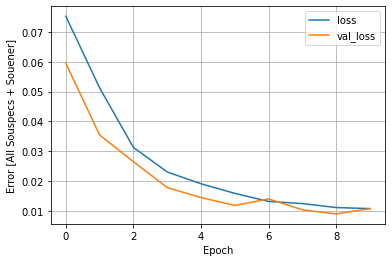

In [40]:
plot_loss(history)

In [105]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)


Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)


Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)


err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [106]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,1.929683e+09,1.586585e+13,8222
1,souspecO2,4.228676e+02,3.476818e+06,8222
2,souspecCO,1.118385e+02,9.195365e+05,8222
3,souspecCO2,8.376652e+01,6.887284e+05,8222
4,souspecH2O,1.517236e+02,1.247471e+06,8222
5,souspecOH,1.362359e+02,1.120132e+06,8222
6,souspecH2,2.143617e+01,1.762482e+05,8222
7,souspecCH4,1.082143e+02,8.897381e+05,8222


/home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

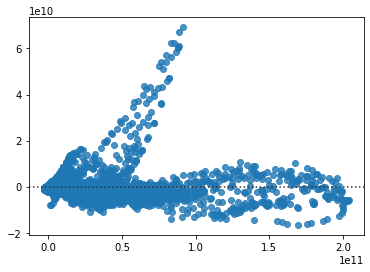

In [107]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values
sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

### Unconstrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding)

In [108]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear")(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
#model.summary()

In [38]:
'''
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)
'''

'\ntf.keras.utils.plot_model(model,to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96)\n'

In [39]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [40]:
halfData = getHalfData()

In [41]:
halfData.keys()

dict_keys(['scaler_species', 'scaler_zmixpca', 'scaler_souener', 'X_tain', 'X_test', 'Zmix_train', 'Zmix_test', 'normalized_species_train', 'normalized_species_test', 'Y_test', 'Y_train', 'normalized_zmixpca_train', 'normalized_zmixpca_test', 'normalized_souener_train', 'normalized_souener_test', 'Xpos_bins_train', 'flame_key_ints_train', 'Xpos_bins_test', 'flame_key_ints_test', 'Xpos_train', 'Xpos_test', 'flame_keys_train', 'flame_keys_test'])

In [42]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

CPU times: user 18.7 s, sys: 1.51 s, total: 20.2 s
Wall time: 13.4 s


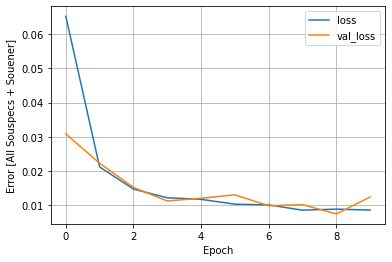

In [43]:
plot_loss(history)

In [44]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions

scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)


Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)


Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)


err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [45]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,1.345913e+09,1.106610e+13,8222
1,souspecO2,4.411686e+02,3.627288e+06,8222
2,souspecCO,9.122138e+01,7.500222e+05,8222
3,souspecCO2,9.037079e+01,7.430286e+05,8222
4,souspecH2O,1.208874e+02,9.939361e+05,8222
5,souspecOH,1.344773e+02,1.105673e+06,8222
6,souspecH2,1.441792e+01,1.185441e+05,8222
7,souspecCH4,2.101197e+02,1.727604e+06,8222


/home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

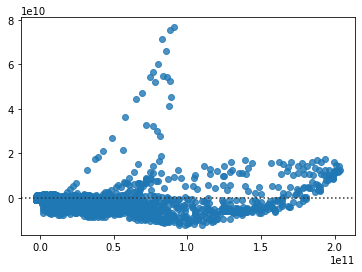

In [46]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values
sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

# ChemTab Implementation Architecture

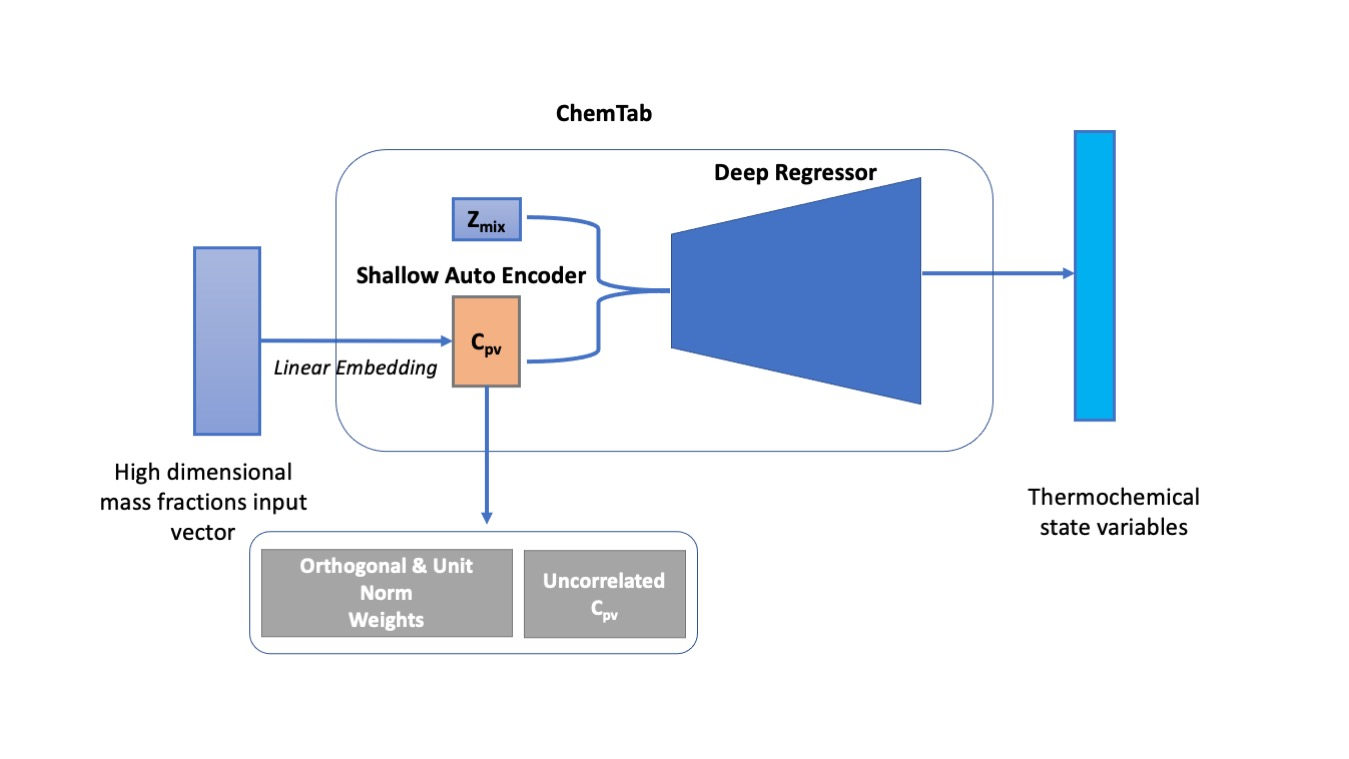

## ChemTab Implementation Formulation

### Overall Network

\begin{equation}\label{eqn:DNN}
    \begin{aligned}
      f_{\mathcal{\theta}}(y) = W^{[L-1]}\mathcal{\sigma} \: \mathcal{\rm o} \: (W^{[L−2]}\mathcal{\sigma} \: \mathcal{\rm o} \: (\dots(W^{[1]}\mathcal{\sigma} \: \mathcal{\rm o} \: (W^{[0]}y + b^{[0]}) + b^{[1]})\dots) + b\\
     \textrm{where,} \quad W^{[l]} \in R^{m_{l+1} \: \times \: m_{l}}\\
      b^{[l]} = R^{m_{l+1}}\\
      m_{0} = d_{in} = d\\
      m_{L} = d_{out}\\
      \mathcal{\sigma} \: \textrm{is a scalar/activation function}\\ 
      \mathcal{\rm o} \: \textrm{is an entry-wise operation}\\
      m \: \textrm{is the number of neurons}\\
      in = s \times n\\
      s = \textrm{the number of species in the mechanism}\\
      n = \textrm{the number of data points (no. of flames * axial coordinate range)}\\
      out = \textrm{no. of thermo-chemical variables  }\mathcal{S}\\
    \end{aligned}
\end{equation}

### Layer Specifics
\begin{equation}\label{eqn:DNN-expansion}
    \begin{aligned}
    f_{\mathcal{\theta}}^{[0]}(y) = y \\
    f_{\mathcal{\theta}}^{[1]}(y) = (W^{[0]} f_{\mathcal{\theta}}^{[0]}(y)) \\
    f_{\mathcal{\theta}}^{[l]}(y) = \mathcal{\sigma} \: \mathcal{\rm o} \: (W^{[l−1]} f_{\mathcal{\theta}}^{[l-1]}(y) \:+\: b^{[l-1]} ) \:\:\:  2 \geq l \leq L-1  \\
    f_{\mathcal{\theta}}(y) = f_{\mathcal{\theta}}^{[L]}(y) = \mathcal{\sigma} \: \mathcal{\rm o} \: (W^{[L-1]} f_{\mathcal{\theta}}^{[L-1]}(y) \:+\: b^{[L-1]} ) 
    \end{aligned}
\end{equation}

### Optimization Specifics
\begin{equation}\label{eqn:ChemTab-Constraints}
    \begin{aligned}
        \arg\min_{\mathcal{\theta}} \quad \lvert f_{\mathcal{\theta}}(y) - \mathcal{S} \rvert\\
        s.t. \quad W^{[0]T}W^{[0]} = I\\
        \Vert W^{[0]} \Vert = 1\\
        f_{\mathcal{\theta}}^{[1]}(y)^Tf_{\mathcal{\theta}}^{[1]}(y) = I\\
        \textrm{where,} \quad f_{\mathcal{\theta}}(y) \quad \textrm{is regressor's prediction}\\
        \mathcal{S} \quad \textrm{is true thermo-chemical state variables}
    \end{aligned}
\end{equation}


## Ablation Study / Experiments

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Unit Norm)

In [55]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
#model.summary()

In [56]:
'''
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)
'''    

'\ntf.keras.utils.plot_model(model,to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96)\n'

In [57]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [58]:
halfData = getHalfData()

In [59]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

CPU times: user 3min 1s, sys: 14.1 s, total: 3min 15s
Wall time: 2min 13s


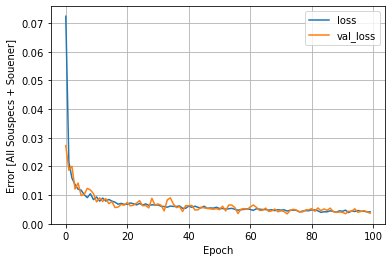

In [60]:
plot_loss(history)

In [61]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)


Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)


Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)


err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [62]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,7.442032e+08,6.118839e+12,8222
1,souspecO2,2.372395e+02,1.950583e+06,8222
2,souspecCO,5.735666e+01,4.715864e+05,8222
3,souspecCO2,2.175347e+01,1.788570e+05,8222
4,souspecH2O,4.903245e+01,4.031448e+05,8222
5,souspecOH,6.697034e+01,5.506301e+05,8222
6,souspecH2,6.828041e+00,5.614015e+04,8222
7,souspecCH4,3.634117e+01,2.987971e+05,8222


/home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

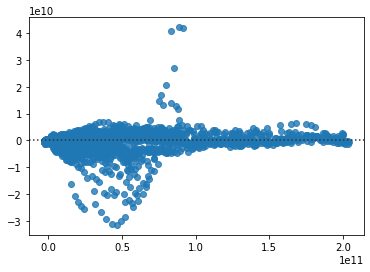

In [63]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values
sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Orthogonal Weights)

In [64]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
#model.summary()

In [48]:
'''
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)
 '''   

'\ntf.keras.utils.plot_model(model,to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96)\n '

In [49]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [50]:
halfData = getHalfData()

In [51]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

Wall time: 54.8 s


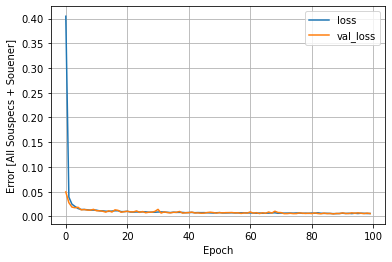

In [52]:
plot_loss(history)

In [53]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)


Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)


Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)


err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [54]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,7.871037e+08,6.471566e+12,8222
1,souspecO2,1.988912e+02,1.635284e+06,8222
2,souspecCO,3.934019e+01,3.234550e+05,8222
3,souspecCO2,3.973378e+01,3.266911e+05,8222
4,souspecH2O,5.379462e+01,4.422993e+05,8222
5,souspecOH,9.268640e+01,7.620676e+05,8222
6,souspecH2,8.390635e+00,6.898780e+04,8222
7,souspecCH4,4.900650e+01,4.029314e+05,8222


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

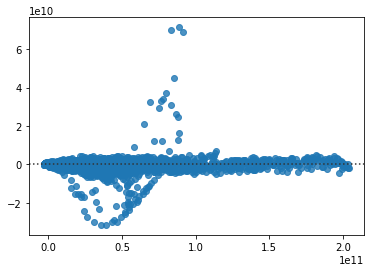

In [55]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values
sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; Uncorrelated Features)

In [65]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)

#model.summary()

In [66]:
#mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM) #--> additive ERROR across sou term with equal importance
#mae = tf.keras.losses.MeanAbsoluteError() #--> (avg across all souspec* (avg ERROR for each souspec across all data pts))

model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [67]:
halfData = getHalfData()

In [68]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

CPU times: user 3min 49s, sys: 18 s, total: 4min 7s
Wall time: 2min 44s


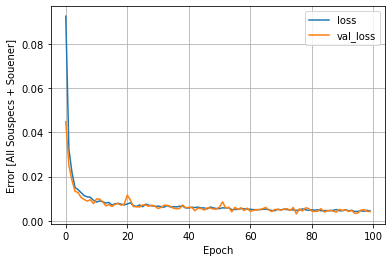

In [69]:
plot_loss(history)

In [70]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)
Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)

err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [71]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,6.112959e+08,5.026075e+12,8222
1,souspecO2,1.748034e+02,1.437233e+06,8222
2,souspecCO,6.300231e+01,5.180050e+05,8222
3,souspecCO2,2.090275e+01,1.718624e+05,8222
4,souspecH2O,4.910439e+01,4.037363e+05,8222
5,souspecOH,5.577613e+01,4.585913e+05,8222
6,souspecH2,8.638430e+00,7.102517e+04,8222
7,souspecCH4,6.066533e+01,4.987903e+05,8222


/home/dwyerdei/.conda/envs/rom-project/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

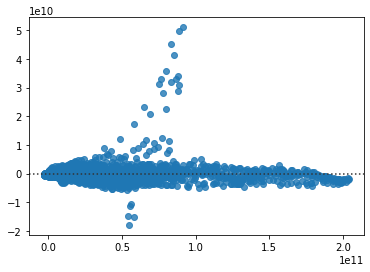

In [72]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values
sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

In [73]:
w_encoder = np.round(model.layers[2].get_weights()[0], 2) #53 * 4 --> 53 Species, 4 Cpvs

In [74]:
#w_encoder

### Unit Norm Constraint on the Weights of the Encoder

In [75]:
print('Encoder weights norm, \n',  np.round(np.sum(w_encoder.T ** 2, axis = 1),3)) #--> L2 Norm

Encoder weights norm, 
 [1.773 1.405 1.36  1.21 ]


### Orthogonal Weights Constraint of the Encoder

In [76]:
np.round(np.dot(w_encoder.T, w_encoder), 3)

array([[ 1.773,  0.369, -0.254,  0.523],
       [ 0.369,  1.405,  0.003, -0.015],
       [-0.254,  0.003,  1.36 ,  0.285],
       [ 0.523, -0.015,  0.285,  1.21 ]], dtype=float32)

### Uncorrelated Features Constraint of the Encoder

In [77]:
encoder_layer = Model(inputs=model.inputs[0], outputs=model.layers[2].output)
encoded_features = np.array(encoder_layer.predict(normalized_species_test))
print('Encoded feature covariance\n', np.round(np.cov(encoded_features.T),3))

Encoded feature covariance
 [[ 0.006  0.     0.    -0.   ]
 [ 0.     0.007  0.     0.   ]
 [ 0.     0.     0.017 -0.001]
 [-0.     0.    -0.001  0.019]]


In [78]:
cpv_df = pd.DataFrame(data=encoder_layer.predict(normalized_species_test), columns=["Cpv1", "Cpv2", "Cpv3", "Cpv4"])

array([[<AxesSubplot:title={'center':'Cpv1'}>,
        <AxesSubplot:title={'center':'Cpv2'}>],
       [<AxesSubplot:title={'center':'Cpv3'}>,
        <AxesSubplot:title={'center':'Cpv4'}>]], dtype=object)

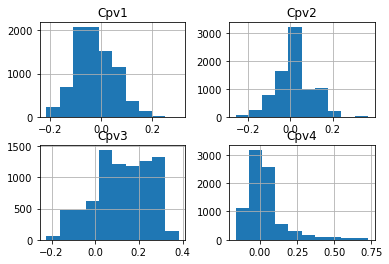

In [79]:
cpv_df.hist()

### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

In [80]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="zmix")

x = layers.Dense(encoding_dim,name='linear_embedding', activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(8, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)


In [72]:
'''
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)
'''

'\ntf.keras.utils.plot_model(model,to_file="model.png",\n    show_shapes=True,\n    show_layer_names=True,\n    rankdir="TB",\n    expand_nested=False,\n    dpi=96)\n'

In [81]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [82]:
halfData = getHalfData()

In [83]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=100, 
                          callbacks=[es])

CPU times: user 4min 3s, sys: 20.2 s, total: 4min 23s
Wall time: 2min 52s


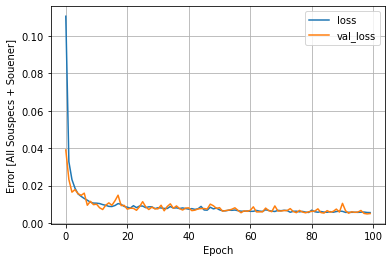

In [84]:
plot_loss(history)

In [85]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

predictions = model.predict([normalized_species_test,Zmix_test])

normalized_souener_pred = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)


Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)

Y_test_df = pd.DataFrame(data=halfData["Y_test"],  columns=dependents)


err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)

In [78]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,9.591666e+08,7.886268e+12,8222
1,souspecO2,3.100430e+02,2.549174e+06,8222
2,souspecCO,6.417466e+01,5.276440e+05,8222
3,souspecCO2,4.202822e+01,3.455561e+05,8222
4,souspecH2O,6.768270e+01,5.564872e+05,8222
5,souspecOH,6.795081e+01,5.586915e+05,8222
6,souspecH2,7.802425e+00,6.415154e+04,8222
7,souspecCH4,2.864547e+01,2.355230e+05,8222


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

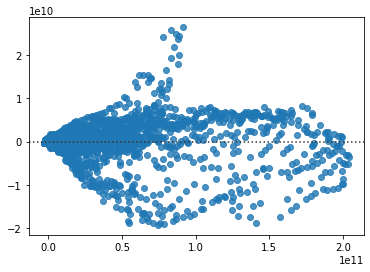

In [79]:
Y_pred = Y_pred_df["souener"].values
Y_test = Y_test_df["souener"].values

sns.residplot(Y_test, getResiduals(Y_test,Y_pred))

#### Testing on the entire dataset

In [80]:
normalized_species_test = halfData["normalized_species_test"]

Zmix_test =  halfData["Zmix_test"]

normalized_species_train = halfData["normalized_species_train"]

Zmix_train =  halfData["Zmix_train"]

normalized_species_all = np.concatenate((normalized_species_test,normalized_species_train))

Zmix_all = np.concatenate((Zmix_test, Zmix_train))


predictions = model.predict([normalized_species_all,Zmix_all])

normalized_souener_pred_all = predictions


scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred_all)
Y_pred_df = pd.DataFrame(data=Y_pred,  columns=dependents)
Y_test_df = pd.DataFrame(data=np.concatenate((halfData["Y_test"],halfData["Y_train"])),  columns=dependents)
err_df = computeErrorAcrossDependents(Y_pred_df, Y_test_df)


'''
Y_pred = Y_pred_df["souener"].values


Y_test = Y_test_df["souener"].values

err = computeAndPrintError(Y_pred, Y_test)
'''


'\nY_pred = Y_pred_df["souener"].values\n\n\nY_test = Y_test_df["souener"].values\n\nerr = computeAndPrintError(Y_pred, Y_test)\n'

In [81]:
err_df

,Dependent,Mean ABS,Total ABS,#Pts
0,souener,9.444429e+08,1.553042e+13,16444
1,souspecO2,3.108655e+02,5.111872e+06,16444
2,souspecCO,6.390556e+01,1.050863e+06,16444
3,souspecCO2,4.180789e+01,6.874890e+05,16444
4,souspecH2O,6.646914e+01,1.093019e+06,16444
5,souspecOH,6.763814e+01,1.112242e+06,16444
6,souspecH2,7.864733e+00,1.293277e+05,16444
7,souspecCH4,2.835044e+01,4.661947e+05,16444


#### Error Density by FlameId & XPos

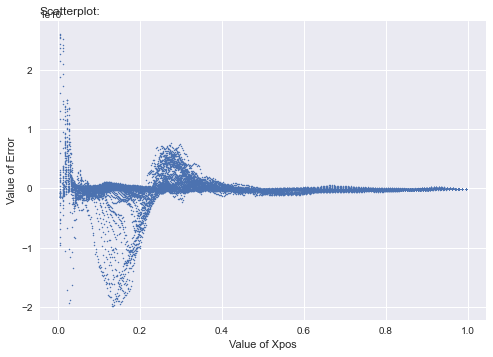

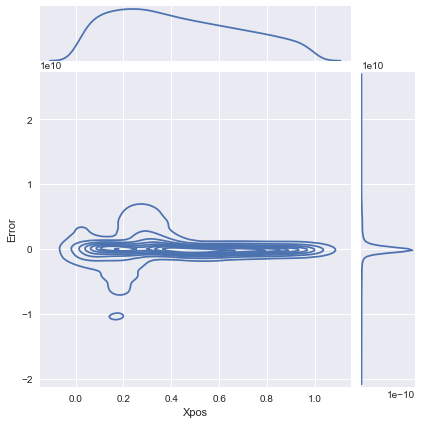

In [82]:
# libraries and data
plt.style.use('seaborn')

#residual/error

residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

Xpos = np.append(halfData["Xpos_test"],halfData["Xpos_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Xpos"]=Xpos
plt_df["Error"] = residuals
# plot
plt.plot( 'Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')

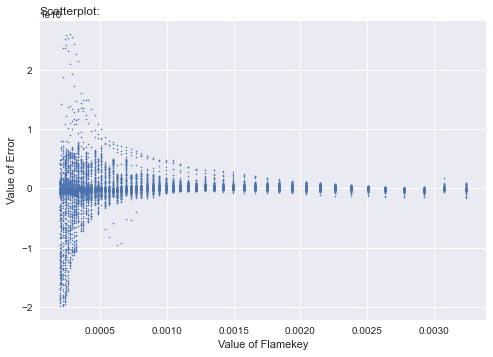

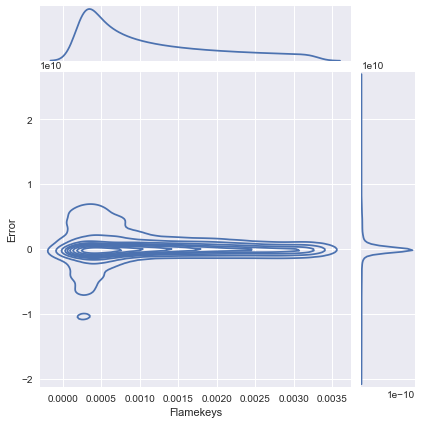

In [83]:
residuals = getResiduals(Y_test_df['souener'].values,Y_pred_df['souener'].values)

flamekeys = np.append(halfData["flame_keys_test"],halfData["flame_keys_train"],axis=0)

plt_df = pd.DataFrame()
plt_df["Flamekeys"]=flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')


In [84]:
#w_encoder

### Unit Norm Constraint on the Weights of the Encoder

In [85]:
print('Encoder weights norm, \n',  np.round(np.sum(w_encoder.T ** 2, axis = 1),3)) #--> L2 Norm

Encoder weights norm, 
 [1.513 1.448 1.408 1.72 ]


### Orthogonal Weights Constraint of the Encoder

In [86]:
np.round(np.dot(w_encoder.T, w_encoder), 3)

array([[ 1.513, -0.101,  0.184,  0.221],
       [-0.101,  1.448, -0.281, -0.124],
       [ 0.184, -0.281,  1.408,  0.057],
       [ 0.221, -0.124,  0.057,  1.72 ]], dtype=float32)

### Uncorrelated Features Constraint of the Encoder

In [87]:
encoder_layer = Model(inputs=model.inputs[0], outputs=model.layers[2].output)
encoded_features = np.array(encoder_layer.predict(normalized_species_test))
print('Encoded feature covariance\n', np.round(np.cov(encoded_features.T),3))

Encoded feature covariance
 [[ 0.013 -0.001 -0.    -0.   ]
 [-0.001  0.017  0.     0.   ]
 [-0.     0.     0.012  0.   ]
 [-0.     0.     0.     0.023]]


In [88]:
cpv_df = pd.DataFrame(data=encoder_layer.predict(normalized_species_test), columns=["Cpv1", "Cpv2", "Cpv3", "Cpv4"])

array([[<AxesSubplot:title={'center':'Cpv1'}>,
        <AxesSubplot:title={'center':'Cpv2'}>],
       [<AxesSubplot:title={'center':'Cpv3'}>,
        <AxesSubplot:title={'center':'Cpv4'}>]], dtype=object)

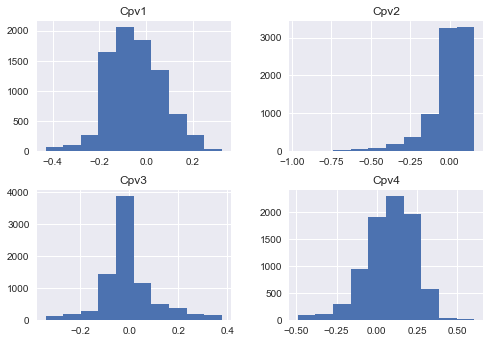

In [89]:
cpv_df.hist()

In [95]:
(df['souener'] < 1 and df['souener'] > -1).sum()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## RESULTS SUMMARY

<table>
<tr>
<td>Method </td>
<td>MAE_PREV</td>
<td>MAE_CURRENT</td>    
</tr>
<tr>
<td>Framework (UnTrimmed Flames Only)</td>
<td>2.24 E+09</td>
<td>2.24 E+09</td>
</tr>
<tr>
<td>Framework (All Flames) </td>
<td>5.19 E+09</td>
<td>5.19 E+09</td>    
</tr>
<tr>    
<td>DNN (Non-Linear Embedding) </td>
<td>9.304 E+08</td>
<td></td>    
</tr>    
<tr>
<td>DNN (Linear Embedding [No Constraints]) </td>
<td>2.042 E+09</td>
<td></td>    
</tr>       
<tr>
<td>ChemTab (Unit Norm Constraints) </td>
<td>6.28 E+08</td>
<td></td>    
</tr>
<tr>
<td>ChemTab (Orthogonal Weights Constraints) </td>
<td>6.05 E+08</td>
<td></td>    
</tr>
<tr>
<td>ChemTab (Uncorrelated Features Constraints) </td>
<td>5.7 E+08</td>
<td>7.08 E+08</td>    
</tr>
<tr>
<td>ChemTab (All Constraints) </td>
<td>8.008 E+08</td>
<td>7.11 E+08 | 6.945E+08 (all data) </td>
</tr>
    
</table>